In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import fetch_openml
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

In [2]:
import matplotlib as mpl

In [3]:
sklearn.__version__

'0.22.1'

In [4]:
# Expect this to take upto 5 minutes
# May need to look for another alternative
mnist = fetch_openml('mnist_784', version=1)

In [5]:
# List out all the keys in the mnist dictionary
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [6]:
# Assign features and target labels
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

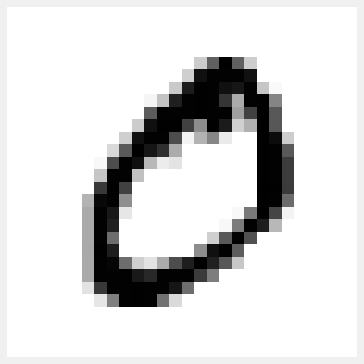

In [7]:
digit_example = X[1]
digit_image = digit_example.reshape(28, 28)

plt.imshow(digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [8]:
# the label of this digit, we need to convert into integers
y[1]

'0'

In [9]:
y = y.astype(np.uint8)

In [10]:
train_index = 60000
X_train = X[:train_index]
X_test = X[train_index:]
y_train = y[:train_index]
y_test = y[:train_index]

#### Start off with a binary classifier

In [11]:
# This is to classify whether a digit is a 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([digit_example])

array([False])

In [18]:
y_train[0], sgd_clf.predict([X_train[0]])

(5, array([ True]))

In [19]:
## Try stratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    print(train_index, test_index)
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/khuongtran/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[19964 19965 19966 ... 59997 59998 59999] [    0     1     2 ... 20331 20342 20359]
0.95035
[    0     1     2 ... 59997 59998 59999] [19964 19965 19966 ... 40088 40125 40127]
0.96035
[    0     1     2 ... 40088 40125 40127] [39988 39989 39990 ... 59997 59998 59999]
0.9604


In [20]:
from sklearn.model_selection import cross_val_score

In [22]:
cross_val_score(sgd_clf, 
                X_train, 
                y_train_5, 
                cv=3,
                scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

#### This looks good, but remember we are doing binary classifier
#### we have 10 labels, 9 of them are not 5.
#### Blindly classify all the numbers as not 5 already reaches an accuracy of 90%
#### Hence accuracy can not be used as a measure in skewed dataset

In [23]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

#### Confusion matrix
<p> 
This is a much better way to evaluate the performance of a classifier. It is also suitable to debug the classifier behavior. It is showing you how many times an instance of a class A got misclassified into another class B.
</p>

In [26]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

|             | Pred (Not 5)| Pred (5)      |
| :---        |    :----:   |          ---: |
| Actual (Not 5)      | True Negative      | False Positive   |
| Actual (5)   | False Negative        | True Positive      |

In [31]:
# In a ideal prediction, all values are correctly classified
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

<p> 
    Another way to evaluate the classifier is using the <i>precision</i> of the classifier and <i> recall </i>.

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
</p>
        <center><img src='./assets/confusion_matrix.png'></center>

In [32]:
from sklearn.metrics import precision_score, recall_score

In [33]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [34]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [35]:
# F1 score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score

In [36]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [42]:
y_scores = sgd_clf.decision_function([X_train[0]])
y_scores

array([2164.22030239])

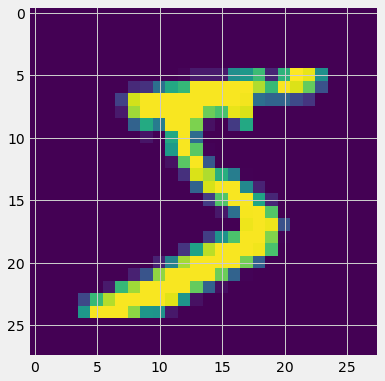

In [43]:
plt.imshow(X_train[0].reshape(28,28))

In [44]:
y_scores = cross_val_predict(sgd_clf,
                            X_train,
                            y_train_5,
                            cv=3,
                            method='decision_function')

In [45]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

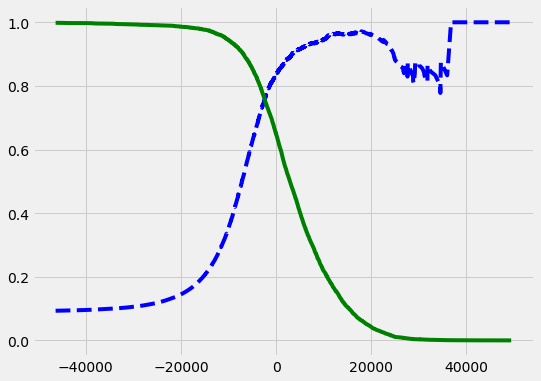

In [51]:
plt.plot(thresholds[2000:], precisions[2000:-1], "b--", label='Precision')
plt.plot(thresholds[2000:], recalls[2000:-1], "g-", label='recall')
plt.show()

In [50]:
len(thresholds)

59966

#### ROC Curve

<p>
The ROC curve plots the true positive rate (another name for recall) against the false positive rate    
</p>
    

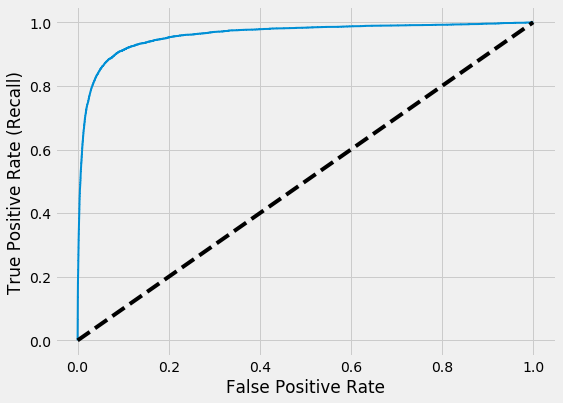

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2, label='ROC')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(
                    forest_clf, 
                    X_train,
                    y_train_5, 
                    cv=3,
                    method='predict_proba'
)

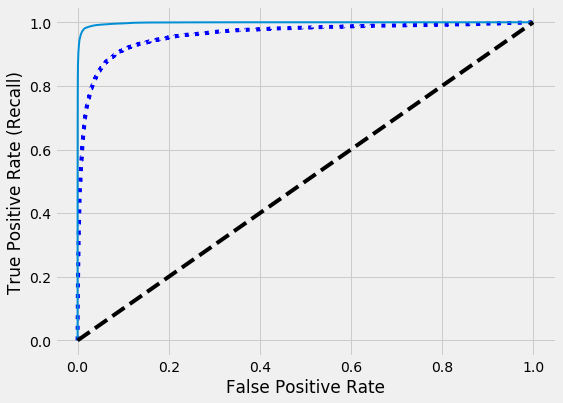

In [58]:
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(
    y_train_5,
    y_scores_forest
)

plt.plot(fpr, tpr, "b:", label="SGD") 
plt.plot(fpr_forest, tpr_forest, linewidth=2, label='ROC')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [61]:
# Use binary classifier to classify 10 digits
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
sgd_clf.predict([X_train[0]]), y_train[0]

(array([3], dtype=uint8), 5)

In [64]:
sgd_clf.predict([X_train[5]]), y_train[5]

(array([2], dtype=uint8), 2)

In [65]:
sgd_clf.decision_function([X_train[5]])

array([[-15541.82888672, -29286.65271153,   3512.16981303,
         -6832.08390768, -19312.77223333,  -9222.09311121,
        -33451.06615947, -21325.87368895,  -2296.78795949,
         -6958.23332214]])

In [66]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [68]:
forest_clf.predict([X_train[5]]),  y_train[5]

(array([2], dtype=uint8), 2)

In [69]:
forest_clf.predict_proba([X_train[5]])

array([[0.01, 0.  , 0.88, 0.01, 0.  , 0.04, 0.01, 0.  , 0.03, 0.02]])

In [70]:
cross_val_score(sgd_clf, 
                X_train, 
                y_train,
                cv=3,
                scoring='accuracy'
               )

array([0.87365, 0.85835, 0.8689 ])

In [71]:
# Scale the input to get better accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, 
                X_train_scaled, 
                y_train,
                cv=3,
                scoring='accuracy'
               )

array([0.8983, 0.891 , 0.9018])

#### Analyze the errors